
# Multiple Correspondence Analysis (MCA)  

## Restaurant Consumer Profile Dataset  

### Portfolio Project — 2025

This notebook performs an end-to-end exploratory analysis of a public restaurant consumer profile dataset using **Multiple Correspondence Analysis (MCA)**. The focus is on understanding behavioural patterns across lifestyle, preference, and demographic attributes; all of which are categorical.

---


# Table of Contents

1. [Introduction](#Introduction)
2. [Methods](#Methods)
3. [Load Raw Data](#Load-Raw-Data)
4. [Data Cleaning & Feature Engineering](#Data-Cleaning)
5. [One-Hot Encoding / Indicator Matrix](#Indicator-Matrix)
6. [Multiple Correspondence Analysis (MCA)](#MCA)
7. [Scree Plot Interpretation](#Scree-Plot)
8. [MCA Biplot Interpretation](#Biplot)
9. [Clustering in MCA Space](#Clustering)
10. [Personality–Indicator Heatmap](#Heatmap)
11. [Conclusion](#Conclusion)

*(Note: Internal links work in Jupyter as long as headings match.)*


# 📘 Introduction
## Multiple Correspondence Analysis of Restaurant Consumer Profiles

This notebook performs an end-to-end Multiple Correspondence Analysis (MCA) on a public, CC0-licensed dataset of restaurant consumer profiles.

The aim is to explore whether underlying behavioural patterns can be identified from categorical lifestyle, preference, and demographic variables.  MCA is appropriate here because it:

 - Reduces many categorical indicators into a small set of interpretable dimensions
 - Shows relationships between categories
 - Positions respondents in a low-dimensional space
 - Enables clustering and behavioural segmentation

## 🔍 Objectives of This Notebook

This notebook follows a complete analysis workflow:

### 1. Load the raw dataset

The dataset contains variables such as:

drink level

 - ambience preference
 - dress preference
 - marital status and children
 - transport mode
 - interest and activity
 - religion
 - personality
 - budget level

Numeric fields (birth year, height, weight) are used for engineered features.

### 2. Clean and prepare the data

Processing includes:

 - converting all strings to lowercase
 - trimming whitespace
 - converting birth year → age-decade groups
 - calculating BMI → clinical BMI groups
 - filtering unrealistic heights (< 1.6 m)
 - dropping rows with missing values

Cleaned data is saved to: "data/processed/userprofiles_cleaned.csv"

### 3. Create the binary indicator matrix

All categorical variables are one-hot encoded into a 65-column indicator matrix suitable for MCA.

Saved to:
data/processed/userprofiles_mca_matrix.csv

### 4. Apply MCA

We compute:

 - row coordinates (respondents)
 - column coordinates (categories)
 - eigenvalues and explained inertia

Dimensions 1 and 2 form the main interpretation.
Dimension 3 (~18% inertia) is included for supplementary exploration.

### 5. Visualise results

Visual outputs include:

 - Scree plot
 - MCA biplot (Dimension 1 × Dimension 2)
 - K-Means clusters in MCA space

Saved to:
data/processed/mca/

### 6. Cluster respondents using K-Means

Clustering is performed on MCA coordinates to identify potential consumer segments.

### 7. Explore personality–indicator relationships

A heatmap shows how personality categories align with lifestyle indicators.
Interpretation remains exploratory due to small group sizes.

## 📌 About the Dataset

The dataset is small (113 rows after cleaning), and many variables are weakly associated.
This limits the sharpness of MCA separation.

However, the dataset is ideal for demonstrating:

 - Categorical data preprocessing
 - Feature engineering
 - Binary indicator construction
 - MCA modelling
 - Cluster analysis
 - Clear, reproducible visualisation

## 🎯 What This Notebook Demonstrates

This notebook showcases:

 - Robust preprocessing of categorical data
 - Creation of engineered variables (BMI, age groups)
 - Construction of a one-hot encoded indicator matrix
 - Dimensionality reduction with MCA
 - Visual interpretation of latent dimensions
 - Clustering in reduced space
 - Exploratory behavioural analysis suitable for portfolio presentation

# Methods

This analysis follows a structured workflow to ensure reproducibility and clarity.  

### 1. Data Loading
The CC0-licensed Restaurant Consumer Profile dataset is loaded from the `data/raw/` directory. The dataset contains lifestyle, preference, and demographic variables, along with height, weight, and birth year.

---

### 2. Data Cleaning
Processing steps include:

- Standardising text (lowercase, stripped whitespace)  
- Converting `birth_year` → age-decade groups  
- Computing BMI as `weight / height²`  
- Assigning BMI clinical categories  
- Filtering unrealistic heights (< 1.6 m)  
- Dropping rows with missing values  

Cleaned data is stored in `data/processed/`.

---

### 3. Binary Encoding (One-Hot Encoding)
All categorical variables are converted into binary indicator variables using one-hot encoding, producing a **65-column** indicator matrix for MCA.

Saved to:  
`data/processed/userprofiles_mca_matrix.csv`

---

### 4. Multiple Correspondence Analysis (MCA)
MCA is applied to the binary indicator matrix to obtain:

- **Row coordinates** (respondents)  
- **Column coordinates** (category signals)  
- **Eigenvalues & explained inertia**  

Dimensions 1 and 2 are the primary focus.

---

### 5. Visualisation
We generate:

- Scree plot (inertia explained per dimension)  
- MCA biplot (Dim 1 × Dim 2)  
- K-Means cluster visualisation  
- Personality–indicator heatmap  

---

### 6. Clustering  
K-Means (k=3) is applied to MCA coordinates to identify behavioural segments.

---

### 7. Interpretation  
Each plot is interpreted immediately after generation using principles of MCA, inertia, and cluster analysis.

---


In [4]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import prince  # MCA implementation

import os

# --------------------------------------------------
# PROJECT ROOT (EDIT THIS LINE ON YOUR MACHINE)
# --------------------------------------------------
# Option 1: Let it default to the current working directory
# PROJECT_ROOT = Path.cwd()

# Option 2: Set path as project root
PROJECT_ROOT = Path(r"C:\users\steve\documents\portfolio-2025")  # <-- change this to your repo folder

print("Assumed project root:", PROJECT_ROOT)

# --------------------------------------------------
# Plot defaults
# --------------------------------------------------
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# --------------------------------------------------
# Paths (relative to project root)
# --------------------------------------------------
RAW_CSV_PATH = PROJECT_ROOT / "python" / "project_04_MCA_user_profiles" / "data" / "restaurant-data-and-consumer-ratings" / "userprofile.csv"

PROCESSED_DIR = PROJECT_ROOT / "python" / "project_04_MCA_user_profiles" / "data" / "mca-outputs"
MCA_DIR = PROCESSED_DIR

# Analysis parameters
ROLE_COLUMN = "personality"   # grouping variable for heatmap
N_COMPONENTS = 5
N_CLUSTERS = 3

# Ensure output directories exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MCA_DIR.mkdir(parents=True, exist_ok=True)

print("Raw CSV path:", RAW_CSV_PATH)

Assumed project root: C:\users\steve\documents\portfolio-2025
Raw CSV path: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\restaurant-data-and-consumer-ratings\userprofile.csv


In [5]:
print("Loading raw data from:", RAW_CSV_PATH)

if not RAW_CSV_PATH.exists():
    raise FileNotFoundError(
        f"Data file not found at {RAW_CSV_PATH}.\n"
        "Edit RAW_CSV_PATH in the configuration cell to point to your local file."
    )

df_raw = pd.read_csv(RAW_CSV_PATH)
df_raw.shape, df_raw.head()

Loading raw data from: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\restaurant-data-and-consumer-ratings\userprofile.csv


((138, 19),
   userID   latitude   longitude smoker     drink_level dress_preference  \
 0  U1001  22.139997 -100.978803  false      abstemious         informal   
 1  U1002  22.150087 -100.983325  false      abstemious         informal   
 2  U1003  22.119847 -100.946527  false  social drinker           formal   
 3  U1004  18.867000  -99.183000  false      abstemious         informal   
 4  U1005  22.183477 -100.959891  false      abstemious    no preference   
 
   ambience transport marital_status        hijos  birth_year    interest  \
 0   family   on foot         single  independent        1989     variety   
 1   family    public         single  independent        1990  technology   
 2   family    public         single  independent        1989        none   
 3   family    public         single  independent        1940     variety   
 4   family    public         single  independent        1992        none   
 
            personality  religion      activity  color  weight  bu

In [6]:
df = df_raw.copy()

# Drop irrelevant columns if present
cols_to_drop = [c for c in ["latitude", "longitude", "the_geom_meter", "color"] if c in df.columns]
df = df.drop(columns=cols_to_drop)
print("After dropping lat/long/geom/color:", df.shape)

# Clean text columns: strip & lowercase
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Ensure birth_year is numeric
if "birth_year" in df.columns:
    df["birth_year"] = pd.to_numeric(df["birth_year"], errors="coerce")

# Compute BMI
df["bmi"] = df["weight"] / (df["height"] ** 2)

# Filter unrealistic adult heights
df = df[df["height"] >= 1.6]
print("After filtering height >= 1.6m:", df.shape)

# BMI clinical categories
df["bmi_group"] = pd.cut(
    df["bmi"],
    bins=[0, 18.5, 25, 30, 35, 40, np.inf],
    labels=["underweight", "normal", "overweight", "obesity_i", "obesity_ii", "obesity_iii"],
    include_lowest=True,
)

# Age decade groups
if "birth_year" in df.columns:
    age_bins = np.arange(1930, 2031, 10)  # 1930–2030 by decade
    age_labels = [f"{y}s" for y in range(1930, 2030, 10)]
    df["age_group"] = pd.cut(df["birth_year"], bins=age_bins, labels=age_labels, right=False)
else:
    df["age_group"] = np.nan

# Drop now-unused numeric fields
for col in ["birth_year", "height", "weight", "bmi"]:
    df = df.drop(columns=[col], errors="ignore")

# Drop userID if present
df = df.drop(columns=["userID"], errors="ignore")

# Drop rows with missing values
df = df.dropna()
print("After dropna:", df.shape)

df.head()

After dropping lat/long/geom/color: (138, 16)
After filtering height >= 1.6m: (113, 17)
After dropna: (113, 14)


,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,interest,personality,religion,activity,budget,bmi_group,age_group
0,false,abstemious,informal,family,on foot,single,independent,variety,thrifty-protector,none,student,medium,normal,1980s
1,false,abstemious,informal,family,public,single,independent,technology,hunter-ostentatious,catholic,student,low,underweight,1990s
2,false,social drinker,formal,family,public,single,independent,none,hard-worker,catholic,student,low,normal,1980s
4,false,abstemious,no preference,family,public,single,independent,none,thrifty-protector,catholic,student,medium,normal,1990s
5,true,social drinker,no preference,friends,car owner,single,independent,variety,hard-worker,none,student,medium,normal,1980s


In [7]:
cleaned_path = PROCESSED_DIR / "userprofiles_cleaned.csv"
df.to_csv(cleaned_path, index=False)
print("Saved cleaned dataset to:", cleaned_path)

Saved cleaned dataset to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\userprofiles_cleaned.csv


In [8]:
categorical_cols = df.columns

X = pd.get_dummies(df[categorical_cols], drop_first=False)
X = X.astype(int)  # ensure numeric 0/1

print("MCA matrix shape:", X.shape)
X.head()

MCA matrix shape: (113, 65)


,smoker_false,smoker_true,drink_level_abstemious,drink_level_casual drinker,drink_level_social drinker,dress_preference_?,dress_preference_elegant,dress_preference_formal,dress_preference_informal,dress_preference_no preference,...,age_group_1930s,age_group_1940s,age_group_1950s,age_group_1960s,age_group_1970s,age_group_1980s,age_group_1990s,age_group_2000s,age_group_2010s,age_group_2020s
0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [9]:
mca_matrix_path = PROCESSED_DIR / "userprofiles_mca_matrix.csv"
X.to_csv(mca_matrix_path, index=False)
print("Saved MCA matrix to:", mca_matrix_path)

binary_cols = list(X.columns)
X_binary = X.copy()

Saved MCA matrix to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\userprofiles_mca_matrix.csv


In [10]:
n_components = min(N_COMPONENTS, len(binary_cols))
print(f"Running MCA with {n_components} dimensions...")

mca = prince.MCA(
    n_components=n_components,
    n_iter=5,
    copy=True,
    check_input=True,
    random_state=42,
).fit(X_binary)

row_coords = mca.row_coordinates(X_binary)
col_coords = mca.column_coordinates(X_binary)
eigenvalues = mca.eigenvalues_

# Explained inertia (handle prince version differences)
try:
    explained_attr = mca.explained_inertia_
    explained = explained_attr() if callable(explained_attr) else explained_attr
except AttributeError:
    total = eigenvalues.sum()
    explained = eigenvalues / total if total > 0 else np.zeros_like(eigenvalues)

eigs_df = pd.DataFrame({
    "dimension": np.arange(1, len(eigenvalues) + 1),
    "eigenvalue": eigenvalues,
    "explained_inertia": explained
})

eigs_df

Running MCA with 5 dimensions...


,dimension,eigenvalue,explained_inertia
0,1,0.081331,0.285695
1,2,0.060424,0.212255
2,3,0.052338,0.183848
3,4,0.047406,0.166526
4,5,0.043179,0.151676


In [11]:
row_coords.index = df.index

row_coords.to_csv(MCA_DIR / "row_coordinates.csv")
col_coords.to_csv(MCA_DIR / "column_coordinates.csv")
eigs_df.to_csv(MCA_DIR / "eigenvalues_explained_inertia.csv", index=False)

categories = {col: sorted(df[col].unique()) for col in df.columns}
with open(MCA_DIR / "userprofiles_categories.json", "w") as f:
    json.dump(categories, f, indent=4)

print("Saved MCA outputs to:", MCA_DIR)

Saved MCA outputs to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs


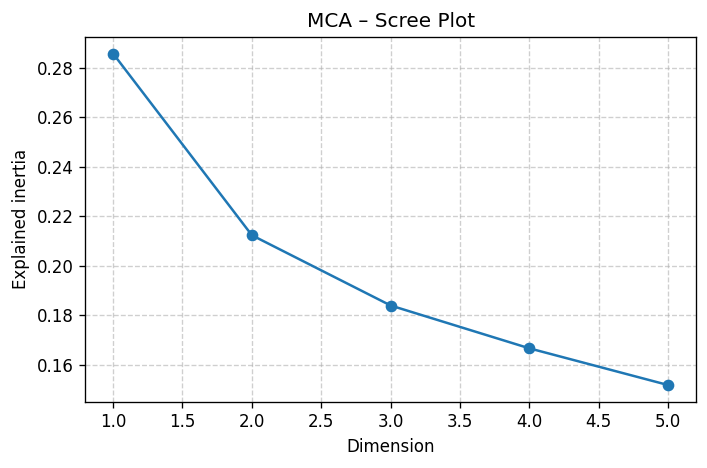

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(eigs_df["dimension"], eigs_df["explained_inertia"], marker="o")
plt.title("MCA – Scree Plot")
plt.xlabel("Dimension")
plt.ylabel("Explained inertia")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Interpretation: Scree Plot

The scree plot shows the proportion of inertia (variation) explained by each MCA dimension.

- **Dimension 1** explains ~28%  
- **Dimension 2** explains ~21%  
- **Dimension 3** explains ~18%  

Together, the first three dimensions explain about **67%** of the structure in the data.

This indicates:
- Dimensions 1 and 2 capture broad, dominant patterns.  
- Dimension 3 captures additional meaningful but more subtle variation.  
- Higher dimensions contribute progressively less and are not included in the main interpretation.

In [13]:
scree_path = MCA_DIR / "mca_scree_plot.png"
plt.savefig(scree_path, dpi=300)
print("Saved scree plot to:", scree_path)

Saved scree plot to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\mca_scree_plot.png


<Figure size 720x480 with 0 Axes>

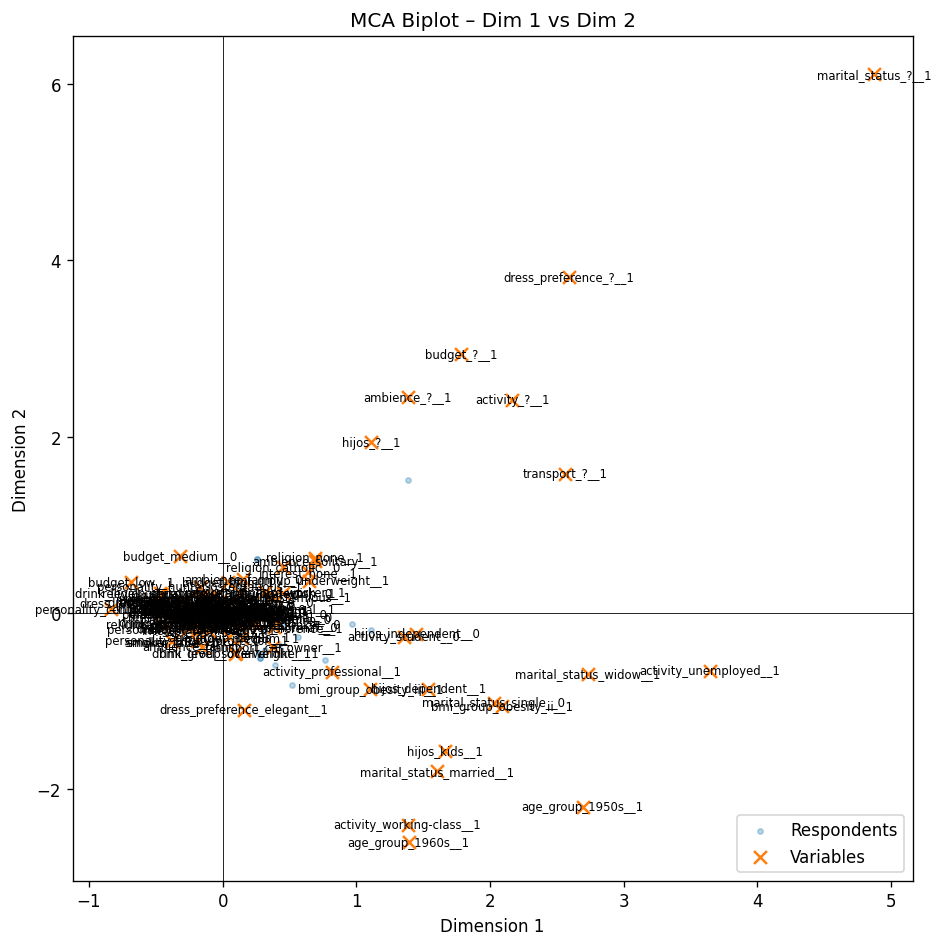

In [14]:
if n_components >= 2:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Respondents
    ax.scatter(row_coords.iloc[:, 0], row_coords.iloc[:, 1],
               s=10, alpha=0.3, label="Respondents")

    # Categories
    ax.scatter(col_coords.iloc[:, 0], col_coords.iloc[:, 1],
               marker="x", s=60, label="Variables")

    for i, label in enumerate(col_coords.index):
        ax.text(col_coords.iloc[i, 0], col_coords.iloc[i, 1],
                label, fontsize=7, ha="center", va="center")

    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_title("MCA Biplot – Dim 1 vs Dim 2")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough dimensions for 2D biplot.")

## Interpretation: MCA Biplot

The MCA biplot displays both respondents (as points) and category indicators (as markers) in the space of Dimensions 1 and 2.

Key observations:

- Many categories cluster near the origin, indicating **weak associations** and limited discriminatory power.
- Categories farther from the origin contribute more to the underlying structure.
- **Dimension 1** appears related to lifestyle expressiveness (dress style, ambience, activity, budget).  
- **Dimension 2** relates loosely to family orientation and social routine.

Interpretation should remain cautious, as small sample sizes and weak relationships reduce separation strength.

In [15]:
biplot_path = MCA_DIR / "mca_biplot_dim1_dim2.png"
fig.savefig(biplot_path, dpi=300)
print("Saved biplot to:", biplot_path)

Saved biplot to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\mca_biplot_dim1_dim2.png


In [16]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning
)

Saved cluster assignments to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\cluster_assignments.csv


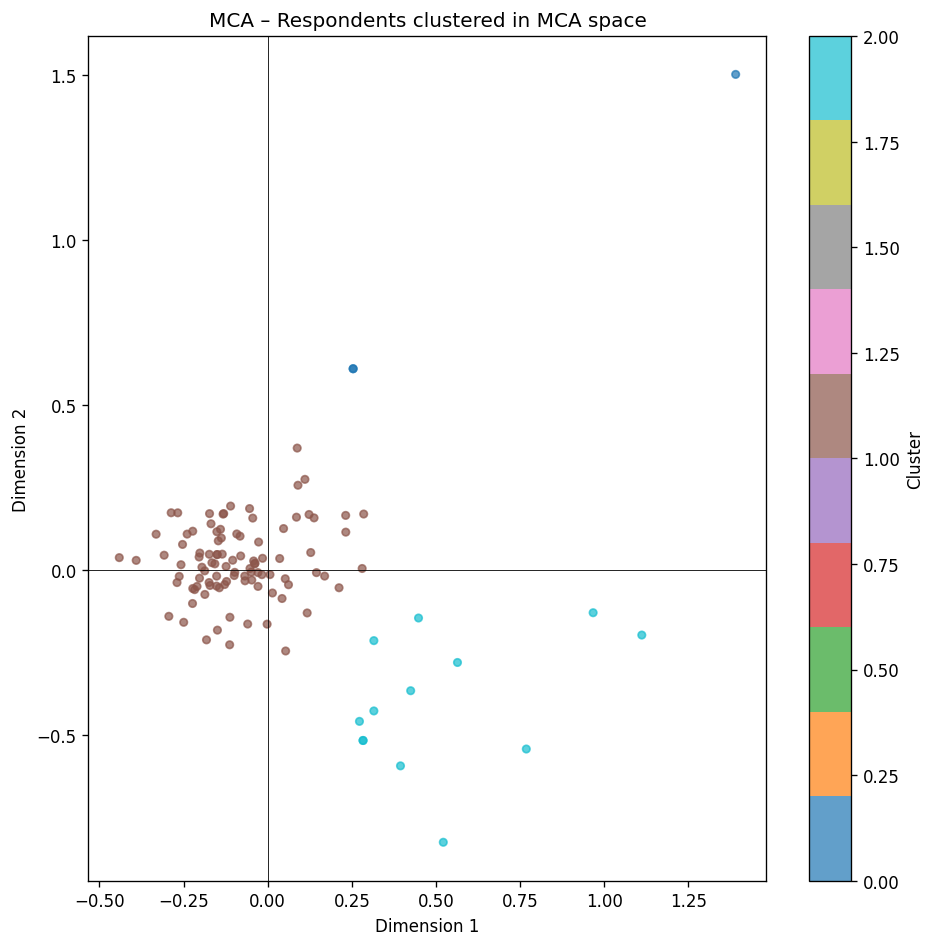

In [18]:
if n_components >= 2:
    X_mca = row_coords.iloc[:, :n_components].values
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(X_mca)

    # Save cluster assignments
    df[["cluster"]].to_csv(MCA_DIR / "cluster_assignments.csv")
    print("Saved cluster assignments to:", MCA_DIR / "cluster_assignments.csv")

    # Plot clusters on Dim 1 vs Dim 2
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(
        row_coords.iloc[:, 0], row_coords.iloc[:, 1],
        c=df["cluster"], cmap="tab10", s=20, alpha=0.7
    )

    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_title("MCA – Respondents clustered in MCA space")

    cbar = plt.colorbar(scatter)
    cbar.set_label("Cluster")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough dimensions for clustering plot.")

## Interpretation: Clustering in MCA Space

K-Means clustering (k=3) identifies three respondent groups:

### Cluster 1 – Central Baseline Group
- Largest cluster
- Respondents close to the origin
- Profiles show no strong defining categories

### Cluster 2 – Lifestyle/Expressive Engagement
- Respondents located along Dimension 1
- More defined choices in activity, ambience, dress, budget

### Cluster 0 – Outlier Category Combination
- Very small cluster
- Driven by low-frequency or extreme category choices
- Interpretation should be cautious

Clusters are approximate, reflecting the modest structure in the dataset.

In [19]:
cluster_plot_path = MCA_DIR / "mca_clusters_dim1_dim2.png"
fig.savefig(cluster_plot_path, dpi=300)
print("Saved cluster plot to:", cluster_plot_path)

Saved cluster plot to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\mca_clusters_dim1_dim2.png


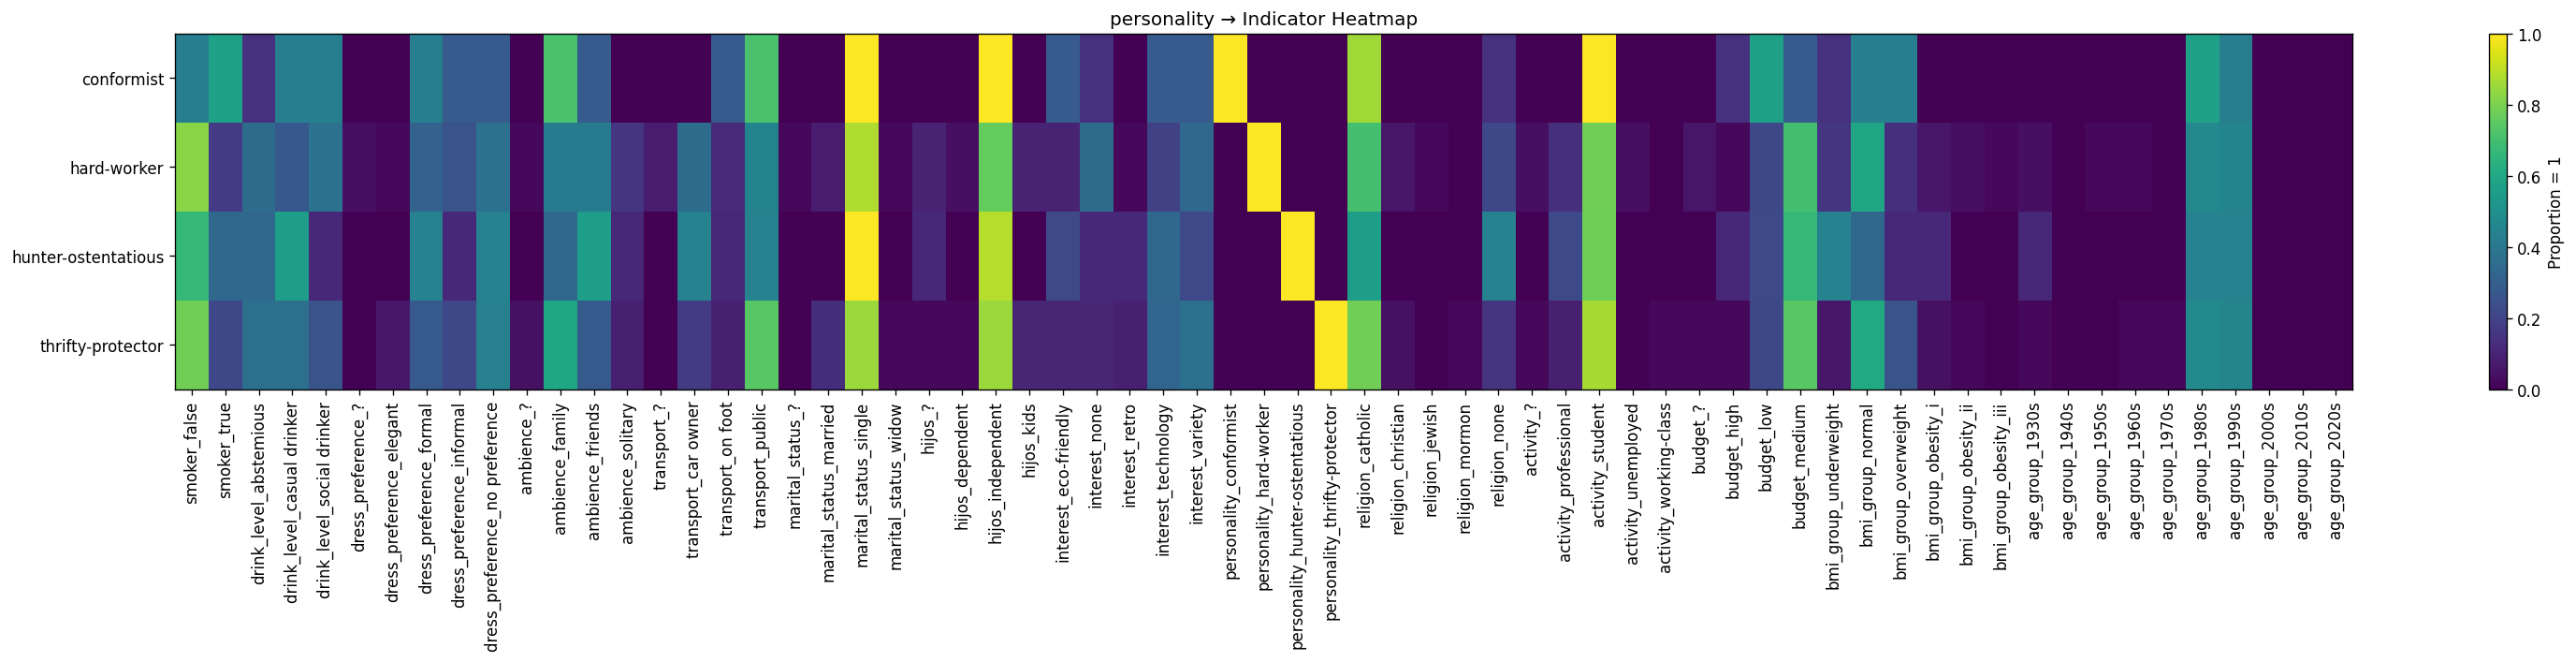

In [20]:
if ROLE_COLUMN in df.columns:
    df_role = pd.concat(
        [df[[ROLE_COLUMN]].reset_index(drop=True),
         X_binary.reset_index(drop=True)],
        axis=1
    )

    role_theme = df_role.groupby(ROLE_COLUMN)[binary_cols].mean()

    plt.figure(figsize=(max(8, len(binary_cols)*0.4),
                        max(6, len(role_theme)*0.4)))

    plt.imshow(role_theme.values, aspect="auto")
    plt.colorbar(label="Proportion = 1")
    plt.xticks(np.arange(len(binary_cols)), binary_cols, rotation=90)
    plt.yticks(np.arange(len(role_theme.index)), role_theme.index)
    plt.title(f"{ROLE_COLUMN} → Indicator Heatmap")
    plt.tight_layout()
    plt.show()
else:
    print(f"ROLE_COLUMN '{ROLE_COLUMN}' not found; skipping heatmap.")

## Interpretation: Personality–Indicator Heatmap

The heatmap shows average indicator values within each personality type.

Patterns are exploratory only due to small sample sizes. General tendencies include:

- Some personality styles align more strongly with lifestyle indicators (e.g., high budget, ambience preferences).
- Others reflect more family-oriented or routine-driven behaviour.
- Several personality groups show diffuse or weak associations, reflecting the dataset’s limited structure.

This heatmap demonstrates the method rather than strong behavioural conclusions.

In [21]:
heatmap_path = MCA_DIR / f"{ROLE_COLUMN}_indicator_heatmap.png"
plt.savefig(heatmap_path, dpi=300)
print("Saved heatmap to:", heatmap_path)

Saved heatmap to: C:\users\steve\documents\portfolio-2025\python\project_04_MCA_user_profiles\data\mca-outputs\personality_indicator_heatmap.png


<Figure size 720x480 with 0 Axes>

# Conclusion

This notebook applied Multiple Correspondence Analysis (MCA) to a public restaurant consumer profile dataset, demonstrating how categorical variables can be explored, encoded, reduced, and visualised.

### Key outcomes:

- A complete preprocessing pipeline was implemented  
- 65 binary indicators were constructed via one-hot encoding  
- MCA identified broad behavioural dimensions despite weak internal structure  
- The first two dimensions captured ~49% of the structure; the first three ~67%  
- K-Means clustering identified a baseline group, a lifestyle-engaged group, and a small outlier group  
- A personality–indicator heatmap provided additional exploratory insights  

### Final remark
Although the dataset is small and lightly structured, the workflow demonstrates a rigorous and transferable analytical method appropriate for consumer profiling, survey analysis, and categorical data exploration.

This notebook forms the reproducible companion to the full project and supports portfolio presentation.